pretrain fully connected network with linear weights, afterwards add parallel synapses; Yann LeCun website is down, get benchmarks from https://web.archive.org/web/20220331130319/https://yann.lecun.com/exdb/mnist/ 

he use mean squred error as loss function, 2-NN with 300 hidden units, accuracy is 95.4%

In [2]:
from training import *

choose hidde

In [65]:
results = train_models(0, H = 30, num_epochs=51)


2-NN (H=30) Epoch 1/51, Loss: 0.4509, Accuracy: 91.39%
2-NN (H=30) Epoch 11/51, Loss: 0.1866, Accuracy: 93.52%
2-NN (H=30) Epoch 21/51, Loss: 0.1611, Accuracy: 93.86%
2-NN (H=30) Epoch 31/51, Loss: 0.1467, Accuracy: 94.91%
2-NN (H=30) Epoch 41/51, Loss: 0.1388, Accuracy: 94.71%
2-NN (H=30) Epoch 51/51, Loss: 0.1330, Accuracy: 94.59%


In [66]:
model_name = list(results['models'].keys())[0]
loss =  results['losses'][model_name]
acc = results['accuracies'][model_name]
model = results['models'][model_name]

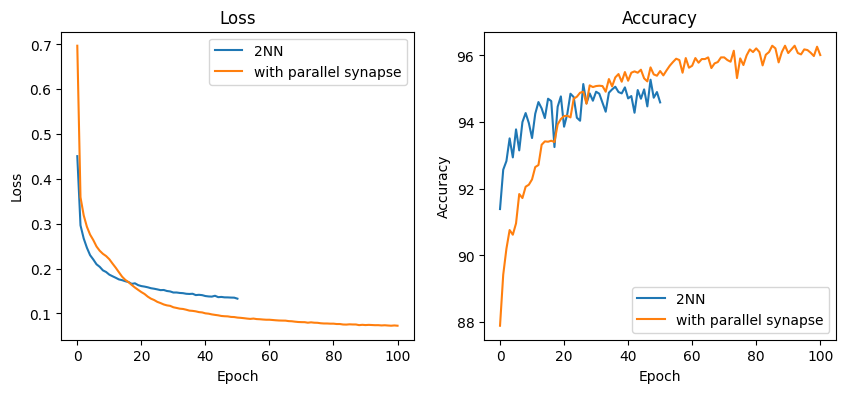

In [69]:
# plot accuracy and loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label = '2NN')
plt.plot(results2['losses'], label = 'with parallel synapse')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(acc, label = '2NN')
plt.plot(results2['accuracies'], label = 'with parallel synapse')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [2]:
# get hidden activation with MNIST inputs
def get_hidden_activation_2NN(model):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
    model.eval()
    hidden = []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.view(-1, 28*28).to(device)
            hidden.append(torch.relu(model.fc1(inputs)).detach().cpu().numpy())
    return np.concatenate(hidden, axis=0)

def get_final_activation_2NN(model):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
    model.eval()
    final = []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.view(-1, 28*28).to(device)
            final.append(model.fc2(torch.relu(model.fc1(inputs))).detach().cpu().numpy())
    return np.concatenate(final, axis=0)


Hidden activation min, max, median (excluding zero), 3*standard deviation (exluding zero):
 	 	 0.0 ,  17.4782 ,  3.0786147 ,  7.040618419647217


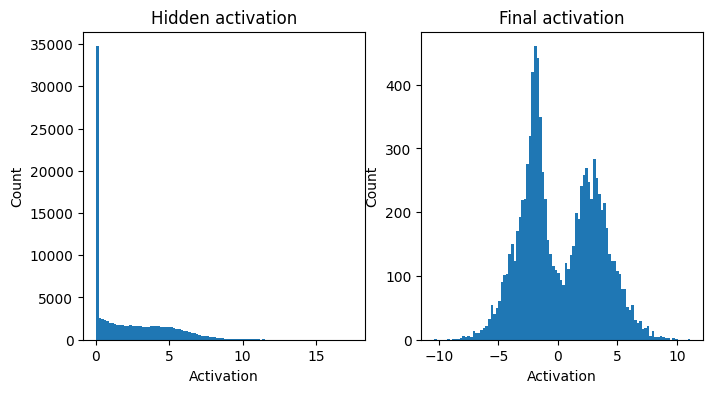

In [80]:
hidden = get_hidden_activation_2NN(model)
final = get_final_activation_2NN(model)
print('Hidden activation min, max, median (excluding zero), 3*standard deviation (exluding zero):\n \t \t', hidden.min(), ', ', 
    hidden.max(), ', ', np.median(hidden[hidden > 0.0001]), ', ', 3*np.std(hidden[hidden > 0.0001]))
# plot histogram of hidden activation
plt.figure(figsize=(8, 4)) 
plt.subplot(1,2,1)
plt.hist(hidden.flatten(), bins=100)
plt.title('Hidden activation')
plt.xlabel('Activation')
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.hist(final.flatten(), bins=100)
plt.title('Final activation')
plt.xlabel('Activation')
plt.ylabel('Count')
plt.show()

In [57]:
(hidden <.1).mean()

0.68682

In [1]:
# define a network with the same architecture as the pretrained network
# replace second layer with parallel synapse
class ParallelSynapse2NN_FixLayer1(nn.Module):
    def __init__(self, 
                input_dim: int, 
                n_synapse: int, 
                hidden_dim: int, 
                weight: torch.Tensor,
                bias: torch.Tensor,
                output_dim: int = 10, 
                hidden_range: Tuple = (0, 40)) -> None:
        super().__init__()
        self.hidden_range = hidden_range
        
        self.fc1 = nn.Linear(hidden_dim, input_dim)
        
        assert weight.shape == (hidden_dim, input_dim)
        assert bias.shape == (hidden_dim,)
        
        # self.fc1.weight.data = weight
        # self.fc1.bias.data = bias
        # self.fc1.weight.requires_grad_(False)
        # self.fc1.bias.requires_grad_(False)
        
        self.parallel_synapse = ParallelSynapseLayer(hidden_dim, 
                                                n_synapse, 
                                                output_dim, 
                                                hidden_range)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.parallel_synapse(x)
        return F.log_softmax(x, dim =1)

NameError: name 'nn' is not defined

In [47]:
input_dim = 28*28
n_synapse = 3
hidden_dim = 50
weight = model.fc1.weight.data.cpu()
bias = model.fc1.bias.data.cpu()
output_dim = 10
hidden_range = (1, 30)

model2 = ParallelSynapse2NN_FixLayer1(
    input_dim, 
    n_synapse, 
    hidden_dim, 
    weight, 
    bias, 
    output_dim, 
    hidden_range
)

In [58]:
def train_models(seed, model, num_epochs=31, device=torch.device("cpu"), verbose=True):
    torch.manual_seed(seed)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
    accuracies = []
    losses = []
        
    for epoch in range(num_epochs): 
        with torch.no_grad():
            model.parallel_synapse.slope.data = torch.clamp(model.parallel_synapse.slope.data, min = 0)
            
            mask = (model.parallel_synapse.ampli.data < 0.1) 
            model.parallel_synapse.ampli.data = torch.clamp(model.parallel_synapse.ampli.data, min = 0.1)
            model.parallel_synapse.thres.data[mask] = torch.rand(mask.sum())  * 30  + 1
            
            model.parallel_synapse.thres.data = torch.clamp(model.parallel_synapse.thres.data, 
                                                        min = model.hidden_range[0], 
                                                        max = model.hidden_range[0])
            
        model.train() 
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs = inputs.view(-1, 28*28).to(device)
            
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.nll_loss(outputs, labels) 
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        losses.append(running_loss / len(trainloader))
        # Validation loop for accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs = inputs.view(-1, 28*28).to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        accuracy = 100 * correct / total 
        accuracies.append(accuracy)
        if verbose and epoch % 10 == 0:
            print(model_name + f" Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(trainloader):.4f}, Accuracy: {accuracy:.2f}%")

    return {'seed': seed, 
            'model': model,
            'accuracies': accuracies,
            'losses': losses
            }



In [59]:
results2 = train_models(0, model2, num_epochs=101)


2-NN (H=30) Epoch 1/101, Loss: 0.6973, Accuracy: 87.89%
2-NN (H=30) Epoch 11/101, Loss: 0.2210, Accuracy: 92.28%
2-NN (H=30) Epoch 21/101, Loss: 0.1477, Accuracy: 94.18%
2-NN (H=30) Epoch 31/101, Loss: 0.1138, Accuracy: 95.08%
2-NN (H=30) Epoch 41/101, Loss: 0.1003, Accuracy: 95.24%
2-NN (H=30) Epoch 51/101, Loss: 0.0908, Accuracy: 95.53%
2-NN (H=30) Epoch 61/101, Loss: 0.0860, Accuracy: 95.69%
2-NN (H=30) Epoch 71/101, Loss: 0.0806, Accuracy: 95.94%
2-NN (H=30) Epoch 81/101, Loss: 0.0772, Accuracy: 96.21%
2-NN (H=30) Epoch 91/101, Loss: 0.0741, Accuracy: 96.07%
2-NN (H=30) Epoch 101/101, Loss: 0.0726, Accuracy: 96.01%


In [3]:
def plot_parallel_synapse_params(model):
    plt.figure(figsize=(10, 3))
    plt.subplot(1,3,1)
    plt.hist(model.parallel_synapse.ampli.data.cpu().numpy().flatten(), bins=20)
    plt.title('Amplitude histogram')

    plt.subplot(1,3,2)
    plt.hist(model.parallel_synapse.slope.data.cpu().numpy().flatten(), bins=20)
    plt.title('Slope histogram')

    plt.subplot(1,3,3)
    plt.hist(model.parallel_synapse.thres.data.cpu().numpy().flatten(), bins=20)
    plt.title('Threshold histogram')

    
    plt.show()


def plot_input_histogram_to_parallel_synapse_layer(model, hidden_act:str = 'sigmoid') -> None:
    '''
    Inputs:
        model: nn.Module
    
    '''
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
    hidden = []
    final = []
    for inputs, labels in testloader:
        inputs = inputs.view(-1, 28*28)#.to(device)
        
        labels = binary_labels(labels)
        if hidden_act == 'sigmoid':
            hidden.append(torch.sigmoid(model.fc1(inputs)).detach().cpu())
            
        else:
            hidden.append(torch.relu(model.fc1(inputs)).detach().cpu())
        final.append(model.parallel_synapse(hidden[-1]).detach().cpu())
    hidden = torch.cat(hidden, dim=0)
    final = torch.cat(final, dim=0)
    plt.figure(figsize=(9, 3 ))
    plt.subplot(1,3,1)
    plt.hist(hidden.data.cpu().numpy().flatten(), bins=100, label='MNIST')
    plt.legend()
    plt.xlabel('hidden layer input')
    plt.ylabel('count')
    plt.title('Histogram, hidden layer input')
    
    f = model.parallel_synapse
    slope = f.slope
    ampli = f.ampli
    thres = f.thres
    input_dim = slope.shape[1]
    n_data = 100
    output_dim = slope.shape[-1]
    input = torch.linspace(0, hidden.data.cpu().numpy().flatten().max(), steps=n_data).reshape(-1, 1)
    input = input.repeat(1, input_dim)
    n_data = input.shape[0]
    n_synapse = slope.shape[0]
    

    x = slope[None, :, :, :].expand(n_data, n_synapse, input_dim, output_dim) \
        * input[:, None, :, None].expand(n_data, n_synapse, input_dim, output_dim)
    x = x - thres[None, :, :, :].expand(n_data, n_synapse, input_dim, output_dim)
    x = torch.tanh(x)
    x = x * ampli[None, :, :, :].expand(n_data, n_synapse, input_dim, output_dim) 
    x = x * f.scaler[None, None, :, :].expand(n_data, n_synapse, input_dim, output_dim)
    x = x.sum(dim=1).squeeze() 
    plt.subplot(1,3,3)
    plt.plot(input[:,0].numpy(), x.detach().numpy()[:,:])
    plt.xlabel('Input')
    plt.title('Aggregate synaptic output')
    
    plt.subplot(1,3,2)
    plt.hist(final.data.cpu().numpy().flatten(), bins=100, label='MNIST')
    ylim = plt.ylim()
    plt.plot(model.theta.data.cpu().numpy()* np.ones((2,)), np.array(ylim), 'r-',  label='theta')
    plt.legend()
    plt.xlabel('output')
    plt.title('Histogram, final layer input')
    
    plt.tight_layout()
    plt.show()
    

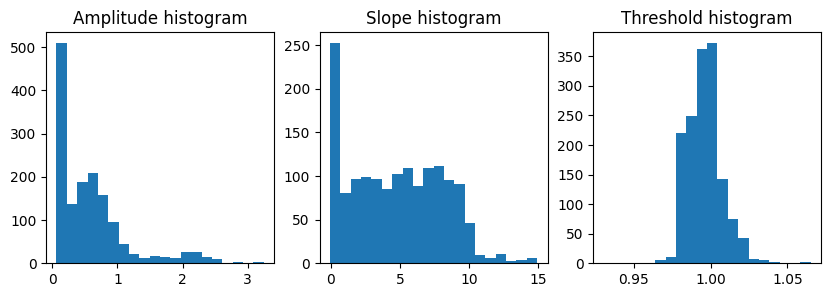

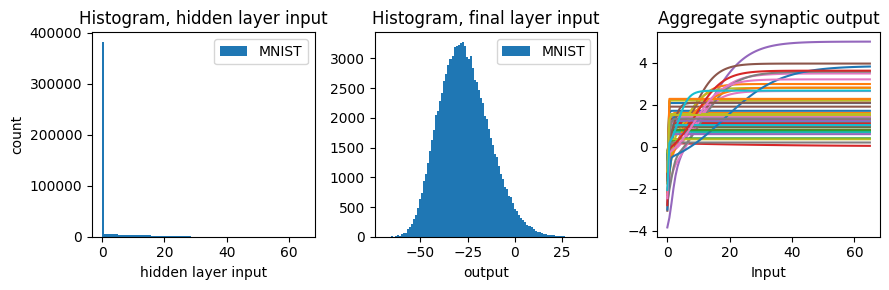

In [ ]:
plot_parallel_synapse_params(results2['model'])
plot_input_histogram_to_parallel_synapse_layer(results2['model'], hidden_act='relu')
            

from above, it seems that softmax loss function makes parallal synapses' thresholds close to 0. \
why?
suppose we have two class, and loss function is  $$l = - y\log(p) - (1-y)log(1-p)$$\
$p$ is $$1\over 1 + \exp(\sum_i^j I_i^j)$$

## train network to perform binary classification with hinge loss

In [6]:
results_binary = train_models_binary(1,
                        M = 3,  
                        H = 10, 
                        in_dim = 28, 
                        out_dim = 1, 
                        num_epochs = 51,
                        verbose = True)

2-NN (H=10) Epoch 1/51, Loss: 9.5553, Accuracy: 93.40%
2-NN (H=10) Epoch 11/51, Loss: 2.8271, Accuracy: 96.23%
2-NN (H=10) Epoch 21/51, Loss: 2.5050, Accuracy: 96.48%
2-NN (H=10) Epoch 31/51, Loss: 2.3501, Accuracy: 96.70%
2-NN (H=10) Epoch 41/51, Loss: 2.2210, Accuracy: 96.54%
2-NN (H=10) Epoch 51/51, Loss: 2.1092, Accuracy: 96.68%


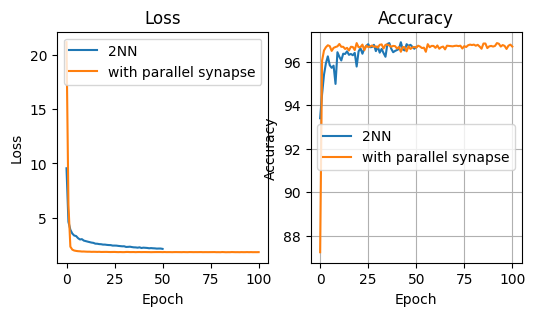

Hidden activation min, max, median (excluding zero), 3*standard deviation (exluding zero):
 	 	 0.0 ,  70.199425 ,  8.169928 ,  26.98795795440674


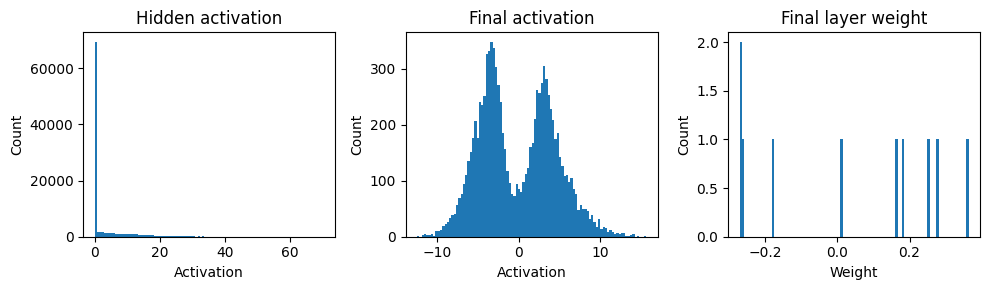

In [33]:
model_name = list(results_binary['models'].keys())[0]
loss =  results_binary['losses'][model_name]
acc = results_binary['accuracies'][model_name]
model = results_binary['models'][model_name]
# plot accuracy and loss
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.plot(loss, label = '2NN')
plt.plot(results2['losses'], label = 'with parallel synapse')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(acc, label = '2NN')
plt.plot(results2['accuracies'], label = 'with parallel synapse')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

hidden = get_hidden_activation_2NN(model)
final = get_final_activation_2NN(model)
print('Hidden activation min, max, median (excluding zero), 3*standard deviation (exluding zero):\n \t \t', hidden.min(), ', ', 
    hidden.max(), ', ', np.median(hidden[hidden > 0.0001]), ', ', 3*np.std(hidden[hidden > 0.0001]))
# plot histogram of hidden activation
plt.figure(figsize=(10, 3)) 
plt.subplot(1,3,1)
plt.hist(hidden.flatten(), bins=100)
plt.title('Hidden activation')
plt.xlabel('Activation')
plt.ylabel('Count')

plt.subplot(1,3,2)
plt.hist(final.flatten(), bins=100)
plt.title('Final activation')
plt.xlabel('Activation')
plt.ylabel('Count')

plt.subplot(1,3,3)
plt.hist(model.fc2.weight.data.cpu().numpy().flatten(), bins=100)
plt.xlabel('Weight')
plt.ylabel('Count')
plt.title('Final layer weight')
plt.tight_layout()
plt.show()


In [7]:
class ParallelSynapseLayer_FlipSign(nn.Module):
    def __init__(self, 
                input_dim: int, 
                n_synapse: int, 
                output_dim: int, 
                input_range: Tuple = (-1, 1)) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.n_synapse = n_synapse
        self.output_dim = output_dim
        
        self.thres = nn.Parameter(torch.rand(
            self.n_synapse, self.input_dim, self.output_dim) * (input_range[1] - input_range[0]) + input_range[0])
        self.slope = nn.Parameter(5 * torch.rand(self.n_synapse, self.input_dim, self.output_dim))
        self.ampli = nn.Parameter(torch.rand(self.n_synapse, self.input_dim, self.output_dim))
        self.scaler = nn.Parameter(torch.rand(self.input_dim, self.output_dim))
        
    def forward(self, input: Tensor):
        '''
        Inputs:
            input: (n_data, input_dim)

        Returns:
            output: (n_data, output_dim)
        '''
        n_data = input.shape[0]
        x = self.slope[None, :, :,:].expand(n_data, self.n_synapse, self.input_dim, self.output_dim) * \
            input[:, None, :, None].expand(n_data, self.n_synapse, self.input_dim, self.output_dim)
        x = x - self.thres[None, :,:,:].expand(n_data, self.n_synapse, self.input_dim, self.output_dim)
        x = (self.ampli[None, :, :,:]**2).expand(n_data, self.n_synapse, self.input_dim, self.output_dim) * \
            torch.tanh(x) * self.scaler[None, None, :, :].expand(n_data, self.n_synapse, self.input_dim, self.output_dim)
        x = x.sum(dim=(1,2)).squeeze() 
        return x


In [8]:
# define a network with the same architecture as the pretrained network
# replace second layer with parallel synapse
class ParallelSynapse2NN_FixLayer1_Binary(nn.Module):
    def __init__(self, 
                input_dim: int, 
                n_synapse: int, 
                hidden_dim: int, 
                weight: torch.Tensor,
                bias: torch.Tensor,
                output_dim: int = 10, 
                hidden_range: Tuple = (0, 40)) -> None:
        super().__init__()
        self.hidden_range = hidden_range
        
        self.fc1 = nn.Linear(hidden_dim, input_dim)
        
        assert weight.shape == (hidden_dim, input_dim)
        assert bias.shape == (hidden_dim,)
        assert output_dim == 1
        
        self.fc1.weight.data = weight
        self.fc1.bias.data = bias
        self.fc1.weight.requires_grad_(False)
        self.fc1.bias.requires_grad_(False)
        self.theta = nn.Parameter(torch.tensor(0.0))  
        self.parallel_synapse = ParallelSynapseLayer_FlipSign(hidden_dim, 
                                                n_synapse, 
                                                output_dim, 
                                                input_range = self.hidden_range)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.parallel_synapse(x)
        return (x - self.theta).squeeze()

In [29]:
input_dim = 28*28
n_synapse = 10
hidden_dim = 10
weight = model.fc1.weight.data.cpu()
bias = model.fc1.bias.data.cpu()
output_dim = 1
hidden_range = (0, 12)

model2 = ParallelSynapse2NN_FixLayer1_Binary(
    input_dim, 
    n_synapse, 
    hidden_dim, 
    weight, 
    bias, 
    output_dim, 
    hidden_range
)

In [30]:
def train_models_binary(seed, model, num_epochs=31, device=torch.device("cpu"), verbose=True):
    
    torch.manual_seed(seed)
    model.to(device)
    criterion = ()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)
    accuracies = []
    losses = []
        
    for epoch in range(num_epochs): 
        with torch.no_grad():
            slope_thres = 0.01
            mask = (model.parallel_synapse.slope.data < slope_thres) 
            model.parallel_synapse.slope.data = torch.clamp(model.parallel_synapse.slope.data, min = slope_thres)
            model.parallel_synapse.thres.data[mask] = torch.rand(mask.sum()) * model.hidden_range[1] + model.hidden_range[0]
            
            ampli_thres = 0.1
            mask = (model.parallel_synapse.ampli.data**2 < ampli_thres) 
            model.parallel_synapse.thres.data[mask] = torch.rand(mask.sum()) * model.hidden_range[1] + model.hidden_range[0]
            model.parallel_synapse.ampli.data[mask] = np.sqrt(ampli_thres)
            
            model.parallel_synapse.thres.data = torch.clamp(model.parallel_synapse.thres.data, min = model.hidden_range[0] )
            
        model.train() 
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs = inputs.view(-1, 28*28).to(device)
            label = binary_labels(labels).to(device)
            # labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = hingeLoss(outputs, binary_labels(labels), margin= 1) 
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        losses.append(running_loss / len(trainloader))
        # Validation loop for accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs = inputs.view(-1, 28*28).to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                predicted = torch.sign(outputs).squeeze().long()
                total += labels.size(0)
                correct += predicted.eq(binary_labels(labels)).sum().item()

        accuracy = 100 * correct / total 
        accuracies.append(accuracy)
        if verbose and epoch % 10 == 0:
            print(model_name + f" Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(trainloader):.4f}, Accuracy: {accuracy:.2f}%")

    return {'seed': seed, 
            'model': model,
            'accuracies': accuracies,
            'losses': losses
            }



In [31]:
results2 = train_models_binary(0, model2, num_epochs=101)


2-NN (H=10) Epoch 1/101, Loss: 21.2019, Accuracy: 87.23%
2-NN (H=10) Epoch 11/101, Loss: 1.8545, Accuracy: 96.82%
2-NN (H=10) Epoch 21/101, Loss: 1.8297, Accuracy: 96.67%
2-NN (H=10) Epoch 31/101, Loss: 1.8104, Accuracy: 96.65%
2-NN (H=10) Epoch 41/101, Loss: 1.8165, Accuracy: 96.61%
2-NN (H=10) Epoch 51/101, Loss: 1.8084, Accuracy: 96.65%
2-NN (H=10) Epoch 61/101, Loss: 1.8065, Accuracy: 96.64%
2-NN (H=10) Epoch 71/101, Loss: 1.8145, Accuracy: 96.73%
2-NN (H=10) Epoch 81/101, Loss: 1.8015, Accuracy: 96.79%
2-NN (H=10) Epoch 91/101, Loss: 1.8016, Accuracy: 96.70%
2-NN (H=10) Epoch 101/101, Loss: 1.8092, Accuracy: 96.70%


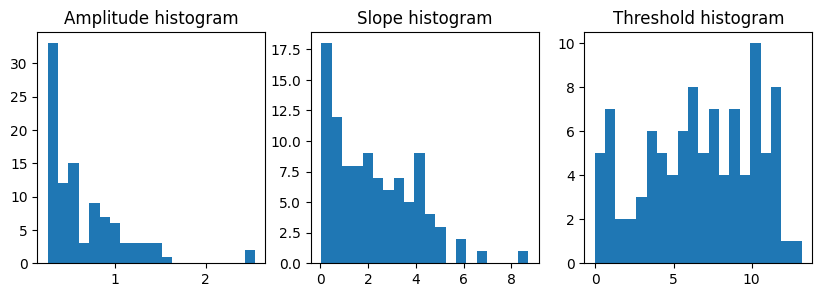

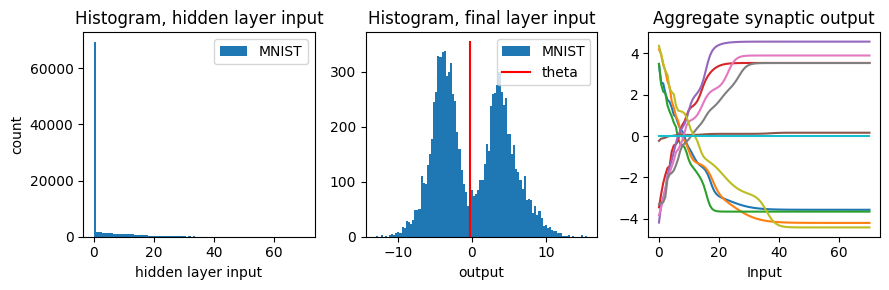

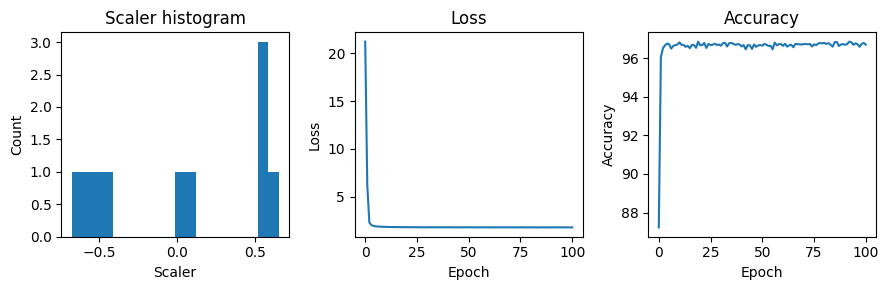

In [32]:
plot_parallel_synapse_params(results2['model'])
plot_input_histogram_to_parallel_synapse_layer(results2['model'], hidden_act='relu')

plt.figure(figsize=(9, 3))
plt.subplot(1,3,1)
plt.hist(results2['model'].parallel_synapse.scaler.data.cpu().numpy().flatten(), bins=20)
plt.xlabel('Scaler')
plt.ylabel('Count')
plt.title('Scaler histogram')



plt.subplot(1,3,2)
plt.plot(results2['losses'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.subplot(1,3,3)
plt.plot(results2['accuracies'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.tight_layout()
plt.show()